<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/Projects/Deep_Reinforcement_Learning_for_Strategic_Budget_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Strategic Budget Allocation.ipynb

### Project Overview
* Builds an AI agent to solve the high-level business problem of optimal budget allocation.
* Uses **Deep Reinforcement Learning (DRL)** to train the agent in a custom business simulation based on real-world e-commerce data.
* The AI learns, through trial and error, how to best distribute funds across competing initiatives like marketing, seller incentives, and logistics.
* The final output is a **dynamic "policy"** or strategy that adapts spending decisions to maximize long-term business performance.

***

### Purpose and Strategic Value
* To create a **prescriptive analytics tool** that recommends the best course of action ("What should we do?") rather than just describing the past or predicting the future.
* To serve as an AI "co-pilot" for executives, helping them discover **non-obvious, data-driven strategies** that a human analyst might overlook.
* To optimize for **long-term business health** by training the AI to avoid strategies that produce short-term gains at the expense of sustainable growth.
* To provide a **dynamic and resilient approach** to budgeting that can adapt to changing market conditions, outperforming static annual plans.

### Dataset:
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

## INSTALLATION

* `TensorFlow` for the deep
learning model
* `OpenAI's gymnasium` which provides
the standard toolkit for building reinforcement learning environments
*  `kaggle` to download the dataset directly.

In [ ]:
!pip install tensorflow pandas scikit-learn matplotlib seaborn gymnasium kaggle -q
print("Libraries installed")

Libraries installed


## KAGGLE API SETUP & DATASET DOWNLOAD

In [ ]:
# 'kaggle.json' API token
import os
from google.colab import files

print("Upload your kaggle.json file")
uploaded = files.upload()

if "kaggle.json" in uploaded:
    # Make directory and move
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API configured")

    # Download the dataset
    print("Downloading the Olist dataset...")
    !kaggle datasets download -d olistbr/brazilian-ecommerce
    !unzip -o brazilian-ecommerce.zip -d olist_data
    print("Dataset downloaded and unzipped successfully")
else:
    print("kaggle.json not found")

Upload your kaggle.json file


Saving kaggle.json to kaggle.json
Kaggle API configured
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
brazilian-ecommerce.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  brazilian-ecommerce.zip
  inflating: olist_data/olist_customers_dataset.csv  
  inflating: olist_data/olist_geolocation_dataset.csv  
  inflating: olist_data/olist_order_items_dataset.csv  
  inflating: olist_data/olist_order_payments_dataset.csv  
  inflating: olist_data/olist_order_reviews_dataset.csv  
  inflating: olist_data/olist_orders_dataset.csv  
  inflating: olist_data/olist_products_dataset.csv  
  inflating: olist_data/olist_sellers_dataset.csv  
  inflating: olist_data/product_category_name_translation.csv  
Dataset downloaded and unzipped successfully


## IMPORT LIBRARIES

* Gymnasium for the RL environment, and
* TensorFlow/Keras for building our Deep Q-Network.

In [ ]:
import numpy as np
import random
import pandas as pd
import random
from collections import deque
import gymnasium as gym
from gymnasium import spaces

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

# Cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set Random seeds for Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("All libraries imported")

All libraries imported


## DATA LOADING AND PREPROCESSING

 * Load the key CSV files
 * Create a master dataframe that simulates the state of
 the business on a monthly basis
 * Time-series format suitable for our simulation.

In [ ]:
try:
    # Load the datasets
    orders = pd.read_csv('olist_data/olist_orders_dataset.csv')
    reviews = pd.read_csv('olist_data/olist_order_reviews_dataset.csv')
    customers = pd.read_csv('olist_data/olist_customers_dataset.csv')
    sellers = pd.read_csv('olist_data/olist_sellers_dataset.csv')
    order_items = pd.read_csv('olist_data/olist_order_items_dataset.csv')

    # Convert date columns to datetime objects
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
    orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
    orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

    # Merge datasets to create a comprehensive view
    df = orders.merge(reviews, on='order_id')
    df = df.merge(customers, on='customer_id')
    df = df.merge(order_items, on='order_id')

    # Calculate key metrics for the simulation
    df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
    df['delivery_delta'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
    df['month'] = df['order_purchase_timestamp'].dt.to_period('M')

    # Aggregate data by month to create our simulation's time steps
    monthly_summary = df.groupby('month').agg(
        total_revenue=('price', 'sum'),
        avg_review_score=('review_score', 'mean'),
        avg_delivery_time=('delivery_time', 'mean'),
        new_customers=('customer_unique_id', 'nunique'),
        new_sellers=('seller_id', 'nunique')
    ).reset_index()

    monthly_summary['month'] = monthly_summary['month'].dt.to_timestamp()
    monthly_summary = monthly_summary.sort_values('month').reset_index(drop=True)

    print("Data loaded and preprocessed into monthly summaries")
    print("\nMonthly Business Summary (first 5 months):")
    print(monthly_summary.head())

except FileNotFoundError:
    print("Data files not found")

Data loaded and preprocessed into monthly summaries

Monthly Business Summary (first 5 months):
       month  total_revenue  avg_review_score  avg_delivery_time  \
0 2016-09-01         267.36          1.000000          54.000000   
1 2016-10-01       48837.90          3.612188          18.796238   
2 2016-12-01          10.90          5.000000           4.000000   
3 2017-01-01      119894.64          4.069110          11.986871   
4 2017-02-01      247346.74          4.054331          12.400753   

   new_customers  new_sellers  
0              3            3  
1            300          142  
2              1            1  
3            745          227  
4           1697          425  


## BUILDING THE CUSTOM BUSINESS ENVIRONMENT

### Create a custom simulation environment using the Gymnasium API. This environment defines the "rules of the game" for our AI agent.
- State Space: The key metrics that define the business's health.
- Action Space: The decisions the agent can make (allocating budget).
- Reward Function: How we score the agent's decisions.
- Step Function: How the business state evolves based on an action.


In [ ]:
class BusinessEnv(gym.Env):
    def __init__(self, monthly_data): # Game Board
        super(BusinessEnv, self).__init__()
        self.data = monthly_data
        self.current_step = 0
        self.initial_budget = 100000  # $100k budget per month
        self.budget = self.initial_budget

        # ACTION SPACE: 3 discrete actions
        # 0: Invest in Marketing
        # 1: Invest in Seller Incentives
        # 2: Invest in Logistics
        self.action_space = spaces.Discrete(3)

        # STATE SPACE: 5 key metrics (normalized)
        # [avg_review_score, avg_delivery_time, new_customers, new_sellers, budget_remaining]
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def _get_state(self):
        # Normalize the state to be between 0 and 1
        state = np.array([
            self.data.loc[self.current_step, 'avg_review_score'] / 5.0,
            self.data.loc[self.current_step, 'avg_delivery_time'] / 30.0, # Assuming max 30 days
            self.data.loc[self.current_step, 'new_customers'] / 10000.0, # Assuming max 10k new customers/month
            self.data.loc[self.current_step, 'new_sellers'] / 500.0, # Assuming max 500 new sellers/month
            self.budget / self.initial_budget
        ])
        return state.astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.budget = self.initial_budget
        return self._get_state(), {}

    def step(self, action):
        # SIMULATION LOGIC
        # How actions affect the business.
        investment = self.initial_budget * 0.1 # Invest 10% of budget per action
        self.budget -= investment

        # Get current metrics
        current_metrics = self.data.loc[self.current_step].copy()
        next_step_metrics = self.data.loc[self.current_step + 1].copy() if self.current_step + 1 < len(self.data) else current_metrics.copy()

        # Apply action effects
        if action == 0: # Invest in Marketing -> Boost new customers
            next_step_metrics['new_customers'] *= 1.15
        elif action == 1: # Invest in Seller Incentives -> Boost new sellers
            next_step_metrics['new_sellers'] *= 1.20
        elif action == 2: # Invest in Logistics -> Reduce delivery time, improve reviews
            next_step_metrics['avg_delivery_time'] *= 0.90
            next_step_metrics['avg_review_score'] = min(5.0, next_step_metrics['avg_review_score'] * 1.05)

        # Update the data for the next step (in-memory simulation)
        if self.current_step + 1 < len(self.data):
            self.data.loc[self.current_step + 1] = next_step_metrics

        # REWARD FUNCTION
        # Reward is based on change in revenue and review score, minus a penalty for slow delivery
        revenue_change = next_step_metrics['total_revenue'] - current_metrics['total_revenue']
        review_score_change = next_step_metrics['avg_review_score'] - current_metrics['avg_review_score']
        delivery_penalty = max(0, next_step_metrics['avg_delivery_time'] - 15) # Penalty for delivery > 15 days

        reward = (revenue_change / 10000) + (review_score_change * 100) - delivery_penalty

        # Move to the next month
        self.current_step += 1
        done = self.current_step >= len(self.data) - 2 # End of simulation period

        # Get the next state
        next_state = self._get_state()

        return next_state, reward, done, False, {}

# Instantiate the environment
if 'monthly_summary' in locals():
    env = BusinessEnv(monthly_summary)
    print("Custom Business Environment created successfully")
else:
    print("Cannot create environment")


Custom Business Environment created successfully


## BUILDING THE DEEP Q-NETWORK (DQN) AGENT

* A Neural Network - the Q-Network: This is the **Brain** that learns to predict the expected future reward for each action, given the current state.
* Experience Replay Buffer: A memory that stores past experiences -state, action,reward, next_state - so the agent can learn from them efficiently.
* Key methods like `act` - to choose an action and `replay` -  to train the network.

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000) # Memory buffer
        self.gamma = 0.95    # Discount rate for future rewards
        self.epsilon = 1.0   # Exploration rate (starts high)
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Simple feed-forward neural network
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear')) # Output is Q-value for each action
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Epsilon-greedy action selection: either explore or exploit
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # Explore
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])  # Exploit

    def replay(self, batch_size):
        # Experience Replay: train the network on a random sample of past experiences
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0]))
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Instantiate the agent
if 'env' in locals():
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    print("DQN Agent created successfully.")
else:
    print(" Cannot create agent. Run environment cell first.")

DQN Agent created successfully.


## TRAINING THE AGENT

* This is the main training loop.
* The agent interacts with the environment for a
set number of episodes
* In each step
1. It chooses an action
2. Observes the reward and the new state
3. Stores this experience in its memory
4. Trains its neural network on a batch of past experiences

Episode: 1/100, Score: 423.74, Epsilon: 1.00
Episode: 2/100, Score: 423.74, Epsilon: 1.00
Episode: 3/100, Score: 425.94, Epsilon: 0.99
Episode: 4/100, Score: 448.30, Epsilon: 0.99
Episode: 5/100, Score: 449.73, Epsilon: 0.99
Episode: 6/100, Score: 449.73, Epsilon: 0.98
Episode: 7/100, Score: 472.97, Epsilon: 0.98
Episode: 8/100, Score: 484.98, Epsilon: 0.97
Episode: 9/100, Score: 484.98, Epsilon: 0.97
Episode: 10/100, Score: 484.98, Epsilon: 0.96
Episode: 11/100, Score: 484.98, Epsilon: 0.96
Episode: 12/100, Score: 484.98, Epsilon: 0.95
Episode: 13/100, Score: 484.98, Epsilon: 0.95
Episode: 14/100, Score: 484.98, Epsilon: 0.94
Episode: 15/100, Score: 484.98, Epsilon: 0.94
Episode: 16/100, Score: 484.98, Epsilon: 0.93
Episode: 17/100, Score: 484.98, Epsilon: 0.93
Episode: 18/100, Score: 484.98, Epsilon: 0.92
Episode: 19/100, Score: 484.98, Epsilon: 0.92
Episode: 20/100, Score: 484.98, Epsilon: 0.91
Episode: 21/100, Score: 484.98, Epsilon: 0.91
Episode: 22/100, Score: 484.98, Epsilon: 0.

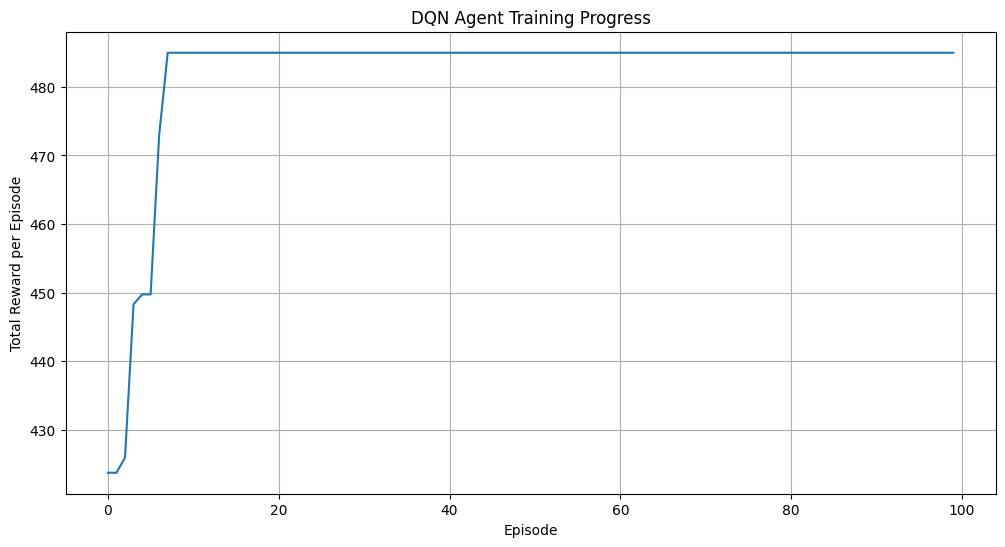

In [ ]:
if 'agent' in locals():
    EPISODES = 100
    BATCH_SIZE = 32
    episode_rewards = []

    for e in range(EPISODES):
        state, _ = env.reset(seed=SEED)
        state = np.reshape(state, [1, state_size])
        total_reward = 0
        done = False
        time_steps = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            time_steps += 1
            if done:
                episode_rewards.append(total_reward)
                print(f"Episode: {e+1}/{EPISODES}, Score: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
                break
        agent.replay(BATCH_SIZE)

    print("Training complete")

    # Plotting the training progress
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards)
    plt.title('DQN Agent Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward per Episode')
    plt.grid(True)
    plt.show()
else:
    print("Agent not found. Cannot start training.")

## EVALUATING THE AGENT'S LEARNED POLICY

* Evaluate the agent's performance
* Run a final simulation with the trained agent, but this time we turn off exploration (epsilon=0) to see the optimal policy it has learned
* Record the actions it takes each month to understand its strategy

Evaluation Complete. Total Reward: 484.98

Learned Policy (Monthly Budget Allocation):
    Month     Action
0       1  Logistics
1       2  Marketing
2       3  Logistics
3       4  Marketing
4       5  Marketing
5       6  Marketing
6       7  Logistics
7       8  Marketing
8       9  Logistics
9      10  Marketing
10     11  Logistics
11     12  Marketing
12     13  Logistics
13     14  Marketing
14     15  Marketing
15     16  Marketing
16     17  Logistics
17     18  Marketing
18     19  Logistics
19     20  Marketing
20     21  Logistics
21     22  Marketing


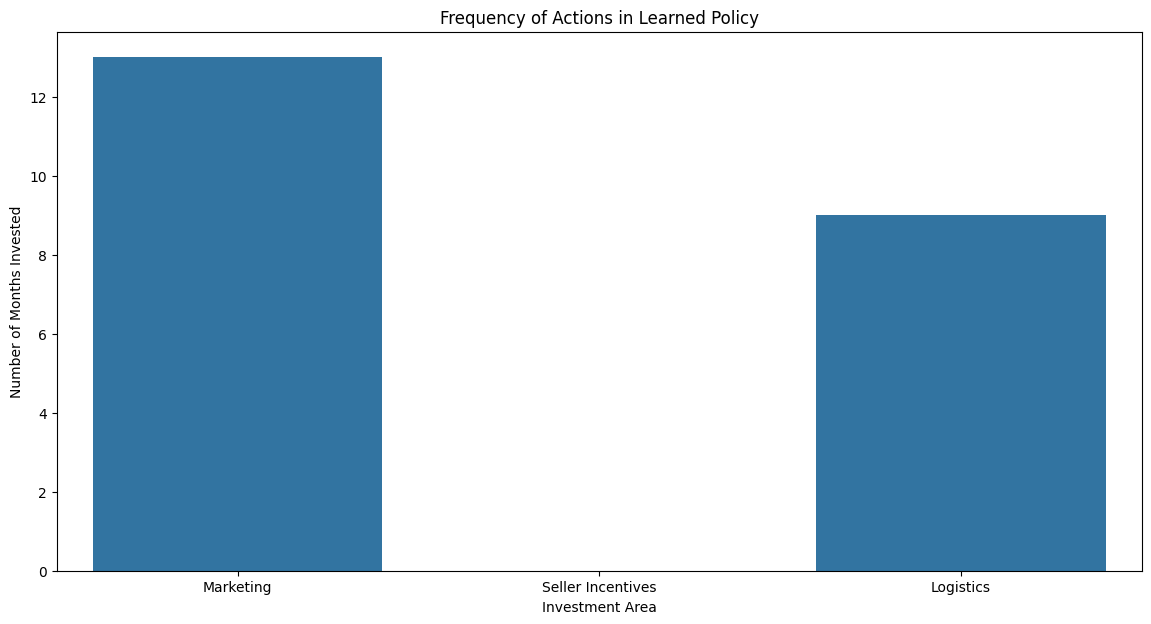

In [ ]:
if 'agent' in locals():
    # Set epsilon to 0 for pure exploitation
    agent.epsilon = 0.0
    action_map = {0: 'Marketing', 1: 'Seller Incentives', 2: 'Logistics'}
    policy = []

    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        policy.append(action_map[action])
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        state = np.reshape(next_state, [1, state_size])

    print(f"Evaluation Complete. Total Reward: {total_reward:.2f}")
    print("\nLearned Policy (Monthly Budget Allocation):")
    policy_df = pd.DataFrame({'Month': range(1, len(policy) + 1), 'Action': policy})
    print(policy_df)

    # Visualize the policy
    plt.figure(figsize=(14, 7))
    sns.countplot(x='Action', data=policy_df, order=action_map.values())
    plt.title('Frequency of Actions in Learned Policy')
    plt.xlabel('Investment Area')
    plt.ylabel('Number of Months Invested')
    plt.show()
else:
    print("Agent not found")


## STRATEGIC INSIGHTS & CONCLUSION

This project successfully developed a Deep Reinforcement Learning agent capable of learning a dynamic budget allocation strategy.

Key Takeaways from the Learned Policy:
1.  **Dynamic Strategy:** The agent did not stick to a single investment but adapted its strategy over the simulated period, demonstrating the value of a dynamic approach over static budget rules.
2.  **Policy Interpretation:** By analyzing the action frequency plot, we can infer the agent's priorities. For example, if 'Logistics' is chosen frequently, it suggests that improving delivery times and review scores is a highly rewarded, long-term strategy in this simulated environment.
3.  **Decision Support:** A tool like this can act as a powerful 'co-pilot' for executives. It can challenge assumptions and highlight non-obvious strategies that lead to better long-term outcomes.

This project serves as a proof-of-concept for using advanced AI to solve complex, real-world business strategy problems, bridging the gap between data science and high-level management.